In [7]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import time
import matplotlib.pyplot as plt

In [8]:
ratings_df = pd.read_csv('ratings.csv')
ratings_df = ratings_df.drop(columns=['timestamp'])

In [9]:
# Ratios for training/test splits
split_ratios = [0.6, 0.7, 0.8, 0.9]

In [10]:
rmses = []
runtimes = []


for ratio in split_ratios:
    
    start_time = time.time()
    
    # Splitting the data into training and test sets
    train_size = int(len(ratings_df) * ratio)
    train_data = ratings_df[:train_size]
    test_data = ratings_df[train_size:]

    # Creating a user-item matrix
    user_item_matrix = train_data.pivot(index='userId', columns='movieId', values='rating').fillna(0)

    # Calculating similarities between users (using cosine similarity)
    user_similarity = np.dot(user_item_matrix, user_item_matrix.T)
    norm = np.array([np.sqrt(np.diagonal(user_similarity))])
    similarity_matrix = user_similarity / (norm * norm.T)

    # Predicting ratings for test set
    test_user_item_matrix = test_data.pivot(index='userId', columns='movieId', values='rating').fillna(0)
    test_users = test_user_item_matrix.index
    test_movies = test_user_item_matrix.columns
    predictions = np.zeros((len(test_users), len(test_movies)))

    for i, user in enumerate(test_users):
        if user in user_item_matrix.index:
            user_similarities = similarity_matrix[user_item_matrix.index.get_loc(user)]
            for j, movie in enumerate(test_movies):
                if movie in user_item_matrix.columns:
                    movie_ratings = user_item_matrix[movie]
                    rated_users = np.where(movie_ratings != 0)[0]
                    similarity_sum = 0
                    weighted_sum = 0
                    for user_index in rated_users:
                        similarity = user_similarities[user_index]
                        similarity_sum += np.abs(similarity)
                        weighted_sum += similarity * movie_ratings.iloc[user_index]
                    if similarity_sum != 0:
                        predictions[i][j] = weighted_sum / similarity_sum

    user_movie_pairs = [(user, movie) for user in test_users for movie in test_movies]
    real_ratings = [user_item_matrix[movie].loc[user] if user in user_item_matrix.index and movie in user_item_matrix.columns else None for user, movie in user_movie_pairs]
    predicted_ratings = predictions.flatten()
    user_ids, movie_ids = zip(*user_movie_pairs)

    # Creating a DataFrame for predictions
    predictions_df = pd.DataFrame({
        'userId': user_ids,
        'movieId': movie_ids,
        'realRating': real_ratings,
        'predictedRating': predicted_ratings.round(1)
    })

    # Removing rows with missing real ratings
    predictions_df = predictions_df.dropna(subset=['realRating'])

    # Calculating Runtime
    end_time = time.time()
    runtime = end_time - start_time   
    runtimes.append(runtime)
    
    # Calculating RMSE Values
    rmse = np.sqrt(mean_squared_error(predictions_df['realRating'], predictions_df['predictedRating']))
    rmses.append(rmse)
    
    # Saving predictions to file
    predictions_filename = f"ratings_predictions_{int(100 - ratio*100)}_cf.csv"
    predictions_df.to_csv(predictions_filename, index=False)

    print(f"ratings_predictions_{int(100 - ratio*100)}_cf - RMSE: {rmse:.2f} , Runtime: {runtime:.2f} seconds")
    
    

ratings_predictions_40_cf - RMSE: 3.38 , Runtime: 13.33 seconds
ratings_predictions_30_cf - RMSE: 3.39 , Runtime: 9.29 seconds
ratings_predictions_20_cf - RMSE: 3.29 , Runtime: 6.65 seconds
ratings_predictions_10_cf - RMSE: 3.30 , Runtime: 3.76 seconds


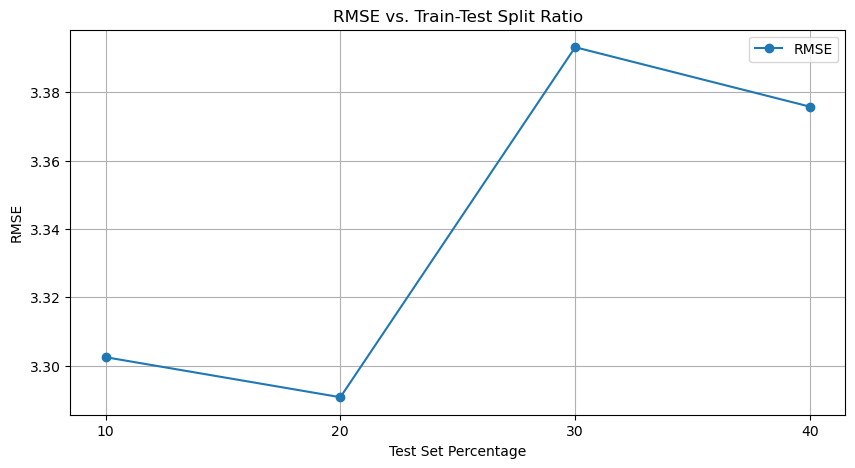

In [11]:
split_percentages = [int(100 - ratio * 100) for ratio in split_ratios]

# Plotting RMSE
plt.figure(figsize=(10, 5))
plt.plot(split_percentages, rmses, label='RMSE', marker='o')
plt.title('RMSE vs. Train-Test Split Ratio')
plt.xlabel('Test Set Percentage')
plt.ylabel('RMSE')
plt.xticks(split_percentages)
plt.legend()
plt.grid(True)
plt.show()


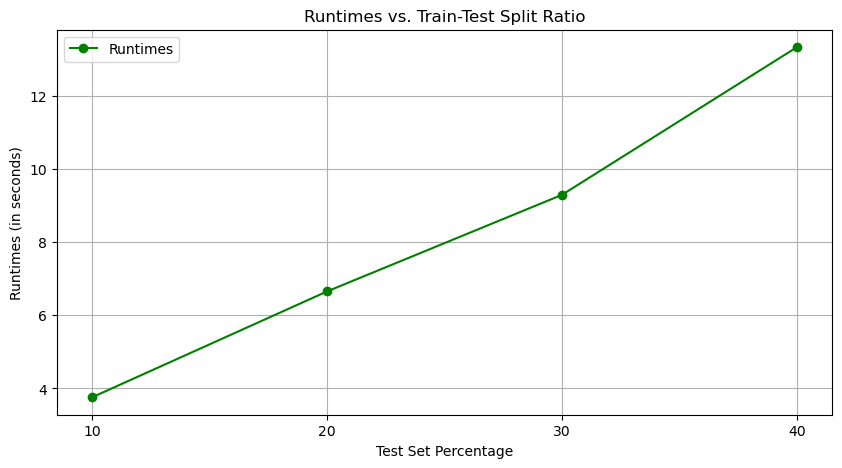

In [12]:
# Plotting Runtimes
plt.figure(figsize=(10, 5))
plt.plot(split_percentages, runtimes, label='Runtimes', marker='o', color='green')
plt.title('Runtimes vs. Train-Test Split Ratio')
plt.xlabel('Test Set Percentage')
plt.ylabel('Runtimes (in seconds)')
plt.xticks(split_percentages)
plt.legend()
plt.grid(True)
plt.show()